# Example 3 - `stripy` interpolation

SRFPACK is a Fortran 77 software package that constructs a smooth interpolatory or approximating surface to data values associated with arbitrarily distributed points. It employs automatically selected tension factors to preserve shape properties of the data and avoid overshoot and undershoot associated with steep gradients.

The next three examples demonstrate the interface to SRFPACK provided through `stripy`


## Notebook contents

   - [Incommensurable meshes](#Define-two-different-meshes)
   - [Analytic function](#The-analytic-function-on-the-different-samplings)
   - [Interpolation](#Interpolation-from-coarse-to-fine)
   - [Interpolate to a grid](#Interpolate-to-grid)


The next example is [Ex4-Gradients](./Ex4-Gradients.ipynb)

---

## Define two different meshes

Create a fine and a coarse mesh without common points

In [1]:
import stripy as stripy

xmin = 0.0
xmax = 10.0
ymin = 0.0
ymax = 10.0
extent = [xmin, xmax, ymin, ymax]

spacingX = 1.0
spacingY = 1.0

cmesh = stripy.cartesian_meshes.elliptical_mesh(extent, spacingX, spacingY, refinement_levels=1)
fmesh = stripy.cartesian_meshes.elliptical_mesh(extent, spacingX, spacingY, refinement_levels=3)

print("coarse mesh points = {}".format(cmesh.npoints))
print("fine mesh points   = {}".format(fmesh.npoints))

coarse mesh points = 53
fine mesh points   = 437


In [2]:
help(cmesh.interpolate)

Help on method interpolate in module stripy.cartesian:

interpolate(xi, yi, zdata, order=1, grad=None, sigma=None) method of stripy.cartesian_meshes.elliptical_mesh instance
    Base class to handle nearest neighbour, linear, and cubic interpolation.
    Given a triangulation of a set of nodes and values at the nodes,
    this method interpolates the value at the given xi,yi coordinates.
    
    Args:
        xi : float / array of floats, shape (l,)
            x Cartesian coordinate(s)
        yi : float / array of floats, shape (l,)
            y Cartesian coordinate(s)
        zdata : array of floats, shape (n,)
            value at each point in the triangulation
            must be the same size of the mesh
        order : int (default=1)
            order of the interpolatory function used:
    
            - `order=0` = nearest-neighbour
            - `order=1` = linear
            - `order=3` = cubic
    
        sigma : array of floats, shape (6n-12)
            precomputed a

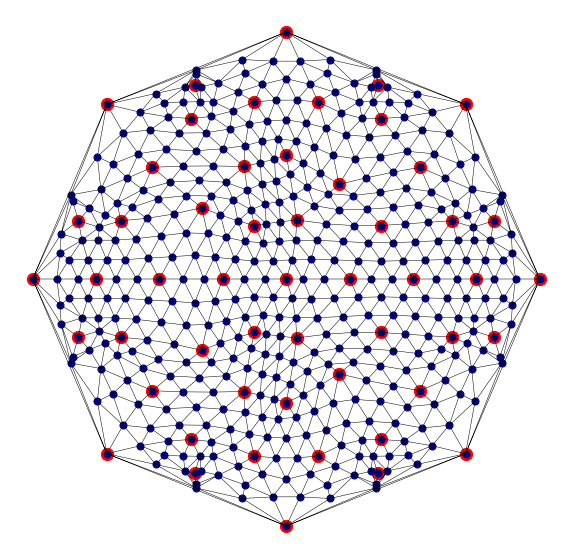

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np



def mesh_fig(mesh, meshR, name):

    fig = plt.figure(figsize=(10, 10), facecolor="none")
    ax  = plt.subplot(111)
    ax.axis('off')

    generator = mesh
    refined   = meshR

    x0 = generator.x
    y0 = generator.y

    xR = refined.x
    yR = refined.y
    

    ax.scatter(x0, y0, color="Red", marker="o", s=150.0)
    ax.scatter(xR, yR, color="DarkBlue", marker="o", s=50.0)
    
    ax.triplot(xR, yR, refined.simplices, color="black", linewidth=0.5)

    fig.savefig(name, dpi=250, transparent=True)
    
    return

mesh_fig(cmesh,  fmesh, "Two grids" )


## Analytic function 

Define a relatively smooth function that we can interpolate from the coarse mesh to the fine mesh and analyse

In [4]:
def analytic(xs, ys, k1, k2):
     return np.cos(k1*xs) * np.sin(k2*ys)

coarse_afn = analytic(cmesh.x, cmesh.y, 0.1, 1.0)
fine_afn   = analytic(fmesh.x, fmesh.y, 0.1, 1.0)

## The analytic function on the different samplings

It is helpful to be able to view a mesh to verify that it is an appropriate choice. Here, for example, we visualise the analytic function on the elliptical mesh.

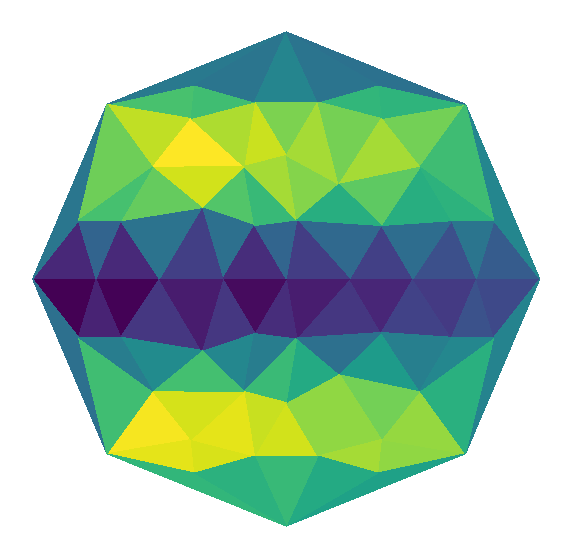

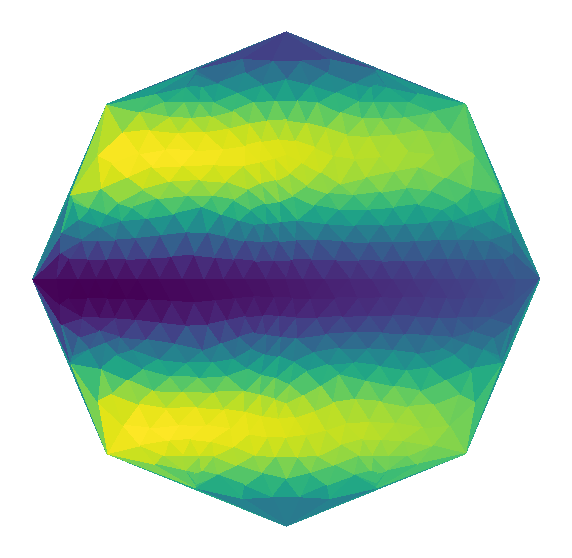

In [5]:
def mesh_field_fig(mesh, field, name):

    fig = plt.figure(figsize=(10, 10), facecolor="none")
    ax  = plt.subplot(111)
    ax.axis('off')
    
    ax.tripcolor(mesh.x, mesh.y, mesh.simplices, field)

    fig.savefig(name, dpi=250, transparent=True)
    
    return

mesh_field_fig(cmesh, coarse_afn, "coarse analytic")
mesh_field_fig(fmesh, fine_afn, "fine analytic")

## Interpolation from coarse to fine

The `interpolate` method of the `Triangulation` takes arrays of x, y points and an array of data on the mesh vertices.
It returns an array of interpolated values and a status array that states whether each value represents an interpolation, extrapolation or neither (an error condition).

The interpolation can be:

1. nearest-neighbour (order=0)
2. linear (order=1)
3. cubic spline (order=3)

In [6]:
interp_c2f1, err = cmesh.interpolate(fmesh.x, fmesh.y, order=1, zdata=coarse_afn)
interp_c2f3, err = cmesh.interpolate(fmesh.x, fmesh.y, order=3, zdata=coarse_afn)

err_c2f1 = interp_c2f1-fine_afn
err_c2f3 = interp_c2f3-fine_afn

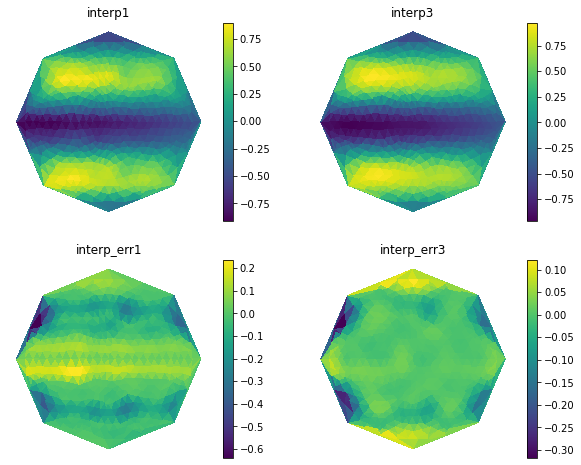

In [7]:
def axis_mesh_field(ax, mesh, field, label):

    ax.axis('off')

    x0 = mesh.x
    y0 = mesh.y
    
    im = ax.tripcolor(x0, y0, mesh.simplices, field)
    ax.set_title(str(label))
    fig.colorbar(im, ax=ax)
    return

    
fig, ax = plt.subplots(2,2, figsize=(10,8))

axis_mesh_field(ax[0,0], fmesh, interp_c2f1, "interp1")
axis_mesh_field(ax[0,1], fmesh, interp_c2f3, "interp3")
axis_mesh_field(ax[1,0], fmesh, err_c2f1, "interp_err1")
axis_mesh_field(ax[1,1], fmesh, err_c2f3, "interp_err3")

## Interpolate to grid

Interpolating to a grid is useful for exporting maps of a region. The `interpolate_to_grid` method interpolates mesh data to a regular grid defined by the user. Values outside the convex hull are extrapolated.

> `interpolate_to_grid` is a convenience function that yields identical results to interpolating over a meshed grid using the `interpolate` method.

In [8]:
resX = resY = 100

grid_x = np.linspace(xmin, xmax, resX)
grid_y = np.linspace(ymin, ymax, resY)

grid_z1 = fmesh.interpolate_to_grid(grid_x, grid_y, interp_c2f3)

# compare with `interpolate` method
grid_xcoords, grid_ycoords = np.meshgrid(grid_x, grid_y)

grid_z2, ierr = fmesh.interpolate(grid_xcoords.ravel(), grid_ycoords.ravel(), interp_c2f3, order=3)
grid_z2 = grid_z2.reshape(resY,resX)

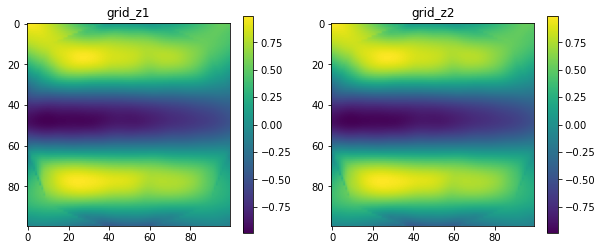

In [9]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))

im1 = ax1.imshow(grid_z1)
im2 = ax2.imshow(grid_z2)

ax1.set_title("grid_z1")
ax2.set_title("grid_z2")

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
plt.show()

The next example is [Ex4-Gradients](./Ex4-Gradients.ipynb)